In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import scipy.signal
import mne
from itertools import cycle
import matplotlib.pyplot as plt
import os.path

mpl.rcParams['figure.max_open_warning'] = 30

select results file and get necessary parameters

In [2]:
# baseline = None
resfile = os.path.join(helpers.resultsdir, 'meg_singledot_201706121047.h5')

#evoked = helpers.load_evoked_container(window=pd.read_hdf(resfile, 'window'))
evoked = helpers.load_evoked_container(window=[0, 0.9])

Reading data/meg_final_data/evoked_sfreq100.0_window0.00-0.90_mag-ave.fif ...
    Found the data of interest:
        t =       0.00 ...     890.00 ms (Unknown)
        0 CTF compensation matrices available
        nave = 480 - aspect type = 100
No baseline correction applied


plotting functions

In [3]:
stylecycler = cycle([':', '--', '-.'])
def plot_minmax_regressors(results, r_names, measure, nperm=0, mode='absmax', ax=None):
    if mode == 'max':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').max(
            level='time').plot(y=r_names, ax=ax);
    elif mode == 'min':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').min(
            level='time').abs().plot(y=r_names, ax=ax);
    elif mode == 'absmax':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).max(level='time').plot(y=r_names, ax=ax)
    elif mode == 'absmean':
        ax = results.xs(measure, axis=1, level='measure').xs(0, level='permnr').abs(
            ).mean(level='time').plot(y=r_names, ax=ax)
        
    cols = [l.get_color() for l in ax.get_lines()]

    nperm += 1
    
    for perm in perms[1:nperm]:
        if mode == 'max':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').max(
                level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'min':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').min(
                level='time').abs().plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmax':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).max(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))
        elif mode == 'absmean':
            results.xs(measure, axis=1, level='measure').xs(perm, level='permnr').abs(
                ).mean(level='time').plot(y=r_names, ax=ax, 
                style=[next(stylecycler)] * len(r_names))

    lines = ax.get_lines()
    for i in range(len(r_names)):
        col = lines[i].get_color()
        for perm in perms[1:nperm]:
            lines[i + perm * len(r_names)].set_color(col)
            
def show_topology_at_peaks(results, r_name, measure, mode='absmax', order=4, vmin=-.1, vmax=.1):
    if mode == 'absmax':
        data = results.loc[0, (measure, r_name)].abs().max(level='time')
    elif mode == 'absmean':
        data = results.loc[0, (measure, r_name)].abs().mean(level='time')
    elif mode == 'max':
        data = results.loc[0, (measure, r_name)].max(level='time')
    else:
        data = results.loc[0, (measure, r_name)].min(level='time').abs()
    
    plt.figure()
    ax = data.plot(title=measure);
    
    # identify local maxima
    times = data.index[scipy.signal.argrelextrema(data.values, 
                                                  np.greater, order=order)] / 1000
    
    data = results.loc[0, (measure, r_name)]
    ev = mne.EvokedArray(data.values.reshape(102, data.index.levels[1].size), 
                         evoked.info, tmin=data.index.levels[1][0], 
                         nave=480*5, comment=r_name)
    
    fig = ev.plot_topomap(times, scale=1, vmin=vmin, vmax=vmax, image_interp='nearest', 
                          title=r_name+' aligned to dot onset', unit=measure, 
                          outlines='skirt');

# Second level analysis

In [4]:
second_level = pd.read_hdf(resfile, 'second_level')
perms = second_level.index.levels[0]

dots = pd.read_hdf(resfile, 'dots')

# Note that these are not exactly the t-values underlying the negative log10 p-values 
# stored in second_level, because scipy.stats uses a different denominator when 
# computing variances and standard deviations than the default used by numpy 
# (N-1 in scipy.stats vs. N in numpy default).
tvals = (second_level.xs('mean', axis=1, level='measure')  / 
         second_level.xs('std', axis=1, level='measure') * np.sqrt(34))

### describe genuine regressors

In [5]:
measure = 'mean'

second_level.xs(measure, axis=1, level='measure').xs(0, level='permnr').describe()

regressor,abs_dot_x_1,abs_dot_x_2,abs_dot_x_3,abs_dot_x_4,abs_dot_x_5,abs_dot_y_1,abs_dot_y_2,abs_dot_y_3,abs_dot_y_4,abs_dot_y_5,...,dot_x_cflip_5,dot_y_1,dot_y_2,dot_y_3,dot_y_4,dot_y_5,entropy,intercept,response,trial_time
count,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,...,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000
mean,0.000547,-0.000423,-0.000626,-0.000572,-0.000231,0.000351,0.000454,0.000844,-0.000004,-0.000081,...,-0.000202,-0.000023,0.000424,0.000224,-0.000038,-0.000361,0.000451,-0.000334,0.000185,0.000750
std,0.013010,0.014534,0.012207,0.014119,0.012418,0.012478,0.011540,0.012203,0.012588,0.011863,...,0.011817,0.020133,0.015637,0.016429,0.016865,0.014235,0.022050,0.061264,0.016800,0.010603
min,-0.047927,-0.055922,-0.056852,-0.061966,-0.061384,-0.052370,-0.041307,-0.073093,-0.039931,-0.039004,...,-0.039781,-0.110936,-0.082227,-0.095816,-0.089887,-0.078014,-0.091535,-0.280805,-0.067631,-0.043466
25%,-0.007231,-0.009626,-0.008349,-0.009533,-0.008003,-0.007570,-0.006531,-0.006477,-0.007739,-0.007916,...,-0.008165,-0.009568,-0.007911,-0.007822,-0.009024,-0.008414,-0.013625,-0.039525,-0.010079,-0.006214
50%,0.000958,-0.000722,-0.000700,-0.000833,-0.000439,0.000367,0.000424,0.000733,-0.000241,-0.000064,...,-0.000267,0.000058,0.000313,0.000272,0.000207,-0.000565,0.001396,0.000156,0.000484,0.001636
75%,0.008455,0.008480,0.007298,0.008105,0.007275,0.008621,0.007817,0.008299,0.007359,0.007453,...,0.007620,0.010132,0.009104,0.008502,0.009356,0.007691,0.015258,0.036894,0.010233,0.008143
max,0.061462,0.066787,0.046297,0.071304,0.056309,0.046262,0.060441,0.065272,0.056967,0.057459,...,0.040431,0.094737,0.078994,0.094668,0.068702,0.077405,0.077925,0.289550,0.092240,0.029725


### describe regressors of first permutation

In [6]:
second_level.xs(measure, axis=1, level='measure').xs(1, level='permnr').describe()

regressor,abs_dot_x_1,abs_dot_x_2,abs_dot_x_3,abs_dot_x_4,abs_dot_x_5,abs_dot_y_1,abs_dot_y_2,abs_dot_y_3,abs_dot_y_4,abs_dot_y_5,...,dot_x_cflip_5,dot_y_1,dot_y_2,dot_y_3,dot_y_4,dot_y_5,entropy,intercept,response,trial_time
count,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9.180000e+03,9180.000000,9180.000000,9180.000000,...,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000,9180.000000
mean,0.000175,-0.000069,0.000044,0.000069,-0.000026,-0.000096,8.342114e-05,-0.000017,-0.000166,-0.000035,...,0.000014,-0.000208,0.000106,-0.000125,-0.000059,0.000024,0.000023,0.000092,-0.000235,-0.000143
std,0.010677,0.012174,0.009997,0.010773,0.010341,0.010169,9.468891e-03,0.010065,0.010106,0.009771,...,0.009945,0.010110,0.009790,0.009438,0.010005,0.010345,0.020799,0.060563,0.010715,0.008030
min,-0.040922,-0.046391,-0.034106,-0.043782,-0.034429,-0.036509,-3.141367e-02,-0.039493,-0.038841,-0.042257,...,-0.034907,-0.043233,-0.034898,-0.041578,-0.038651,-0.042216,-0.077939,-0.279758,-0.041757,-0.029031
25%,-0.006924,-0.008152,-0.006775,-0.006959,-0.006879,-0.006918,-6.314017e-03,-0.006727,-0.007137,-0.006522,...,-0.006745,-0.007041,-0.006566,-0.006414,-0.006931,-0.006701,-0.014147,-0.039030,-0.007169,-0.005535
50%,0.000024,0.000013,0.000018,0.000075,-0.000162,-0.000040,-6.262385e-07,-0.000201,-0.000180,-0.000086,...,-0.000012,-0.000274,-0.000054,0.000093,-0.000262,0.000210,0.000200,0.001530,-0.000022,-0.000202
75%,0.007280,0.008011,0.006848,0.007217,0.006730,0.006723,6.278413e-03,0.006623,0.006705,0.006486,...,0.006629,0.006525,0.006763,0.006265,0.006586,0.006922,0.014224,0.037422,0.006951,0.005224
max,0.036429,0.042344,0.044857,0.044288,0.042067,0.033228,3.375918e-02,0.045951,0.041614,0.035342,...,0.038449,0.039758,0.038554,0.034751,0.044236,0.041837,0.080473,0.286585,0.039240,0.032773


## Show evolution of max (across channels) through the trial

<IPython.core.display.Javascript object>


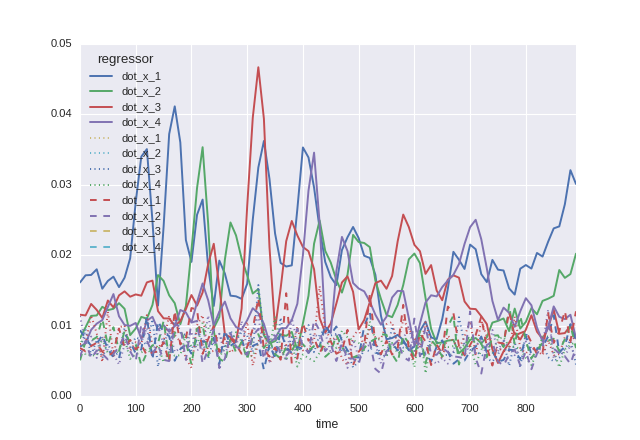

In [7]:
reg = ['dot_x_1', 'dot_x_2', 'dot_x_3', 'dot_x_4']
measure = 'mean'

plot_minmax_regressors(second_level, reg, measure, nperm=2, mode='absmean')

## plot dot regressors individually, but aligned to dot onset

<IPython.core.display.Javascript object>


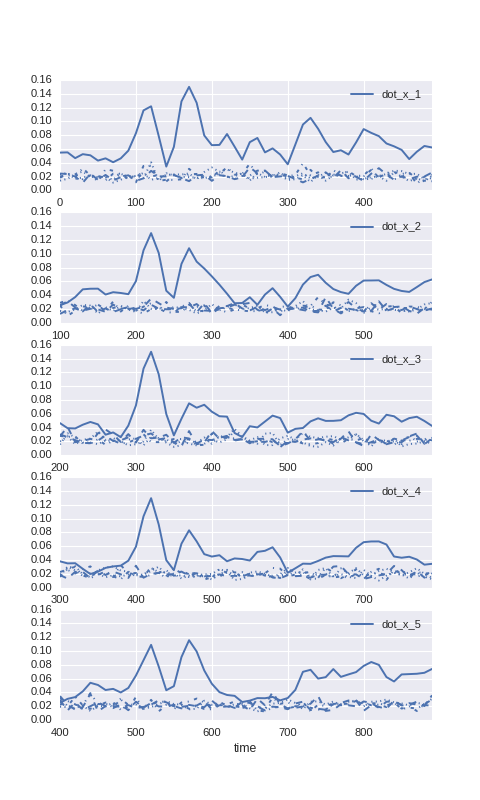

In [11]:
win = [0, 0.49]
r_name = 'dot_x'
measure = 'mean'

regs = ['{}_{}'.format(r_name, d) for d in dots]
R = len(regs)

fig, axes = plt.subplots(R, 1, sharex=False, sharey=True, figsize=[6, 10])

for r, reg in enumerate(regs):
    times = slice(int(100*r + win[0]*1000), int(100*r + win[1]*1000))
    plot_minmax_regressors(second_level.loc[(slice(None), slice(None), times), :], 
                           [reg], measure, nperm=5, mode='absmax', ax=axes[r])
    axes[r].legend([reg])
    

## plot topography of chosen regressor at chosen time point

<IPython.core.display.Javascript object>


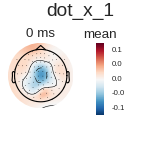

In [30]:
reg = 'dot_x_1'
measure = 'mean'
time = 0.0

data = second_level.loc[(0, slice(None), time*1000), (measure, reg)]

ev = mne.EvokedArray(data.values[:, None], 
                     evoked.info, tmin=time, 
                     nave=480, comment=reg)

fig = ev.plot_topomap(time, scale=1, vmin=-0.1, vmax=0.1, image_interp='nearest', 
                      title=reg, unit=measure, outlines='skirt');